# Simplified implementation for studying pedestrian road-crossing decisions using the COMMOTIONS framework

The code in `sc_scenario.py` in this folder is based on the current version (2020-10-28) of the same file in the root COMMOTIONSFramework folder, but has been simplified to provide easier to understand code that can be used to simulate a scenario where a pedestrian stands next to the road and decides whether or not to cross in front of a car that approaches at constant speed. More specifically:

* All code relating to "behaviour estimation" (optional assumptions `oBEao` and `oBEvs`) has been commented out or removed, leaving only the base modelling framework (like in the `acceleration ctrl tests` folder) extended with the optional assumptions relating to evidence accumulation (`oEA`) and evidence accumulation noise (`oAN`). 
* All model logic has been disabled for car agents (acceleration-controlling agents), such that these always just keep their initial speed.
* Only $\pm$ 1.3 m/s speed changes are allowed for speed-controlling agents (pedestrians), to simplify matters to just a cross/don't cross decision, abstracting away the decision of what walking speed to cross at.

Below a function `run_ped_xing_scenario` is defined, setting up and running the pedestrian crossing scenario, with a default initial speed for the car 10 m/s and initial TTA 3 s. Note that the time step is set to 0.02 s now, lower than the 0.1 s I have mostly used previously - since simulating noisy evidence accumulation doesn't make sense for too large time steps. Also the model parameters $T$ (time constant of the low-pass filter implementing the accumulative value estimates), $\sigma_V$ (value noise intensity), and $\Delta V_th$ (decision threshold) are set to default values. 

In [4]:
import numpy as np
import importlib
import commotions
import sc_scenario
importlib.reload(sc_scenario)
from sc_scenario import CtrlType

DEFAULT_T = 0.5
DEFAULT_SIGMA_V = 0.7
DEFAULT_DELTAV_TH = 0.1
def run_ped_xing_scenario(oEA, oAN, car_speed = 10, tta_init = 3, time_step = 0.02, end_time = 15, \
    T = DEFAULT_T, sigma_V = DEFAULT_SIGMA_V, DeltaV_th = DEFAULT_DELTAV_TH, return_xing_time = False):
    # pedestrian crossing scenario with the pedestrian just at the kerbside 
    # (just 0.1 m outside the collision distance)
    CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
    INITIAL_POSITIONS = np.array([[0,-sc_scenario.SHARED_PARAMS.d_C-.1], [car_speed * tta_init, 0]])
    GOALS = np.array([[0, 5], [-end_time*car_speed, 0]])
    SPEEDS = np.array((0, car_speed)) 

    # turning model features on/off
    optional_assumptions = sc_scenario.get_assumptions_dict(default_value = False, \
        oEA = oEA, oAN = oAN) 

    # setting parameters
    (params, __) = sc_scenario.get_default_params()
    params.T = T
    params.sigma_V = sigma_V
    params.DeltaV_th = DeltaV_th

    # run simulation and plot
    sc_simulation = sc_scenario.SCSimulation(CTRL_TYPES, GOALS, INITIAL_POSITIONS, \
        initial_speeds = SPEEDS, end_time = 15, time_step = 0.02, \
        optional_assumptions = optional_assumptions, params = params)
    sc_simulation.run()

    # get crossing onset time
    xing_sample = np.argwhere(sc_simulation.agents[0].trajectory.long_speed > 0.1)[0]
    xing_time = sc_simulation.time_stamps[xing_sample]
    
    # return what was requested by caller
    if return_xing_time:
        return xing_time
    else:
        print("The pedestrian started crossing the road at time %.2f s." % xing_time)
        return sc_simulation

Below this scenario is run once without evidence accumulation. The plots below show:

* The trajectories of pedestrian (A) and car (B).
* The momentary value $V_a(t)$ and estimated value $\hat{V}_a(t)$ of each action for the pedestrian (left column of plots; the right column are for the car, and remain empty becase these calculations are now not performed for car agents in this simplified implementation). Since there is no evidence accumulation or noise, $\hat{V}_a(t) = V_a(t)$
* The surplus value of each action compared to the "do nothing" action $a_0$, $\hat{\Delta V}_a(t) = \hat{V}_a(t) - \hat{V}_{a_0}(t)$
* Time-series plots of the kinematic states of the agents, where the bottom two panels show the agent distances $d_{CP}$ to the crossing point and the distance $d$ between the agents.

In this simulation, the agent immediately decides to pass in front of the car.


The pedestrian started crossing the road at time 0.04 s.


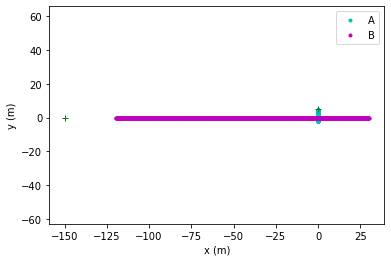

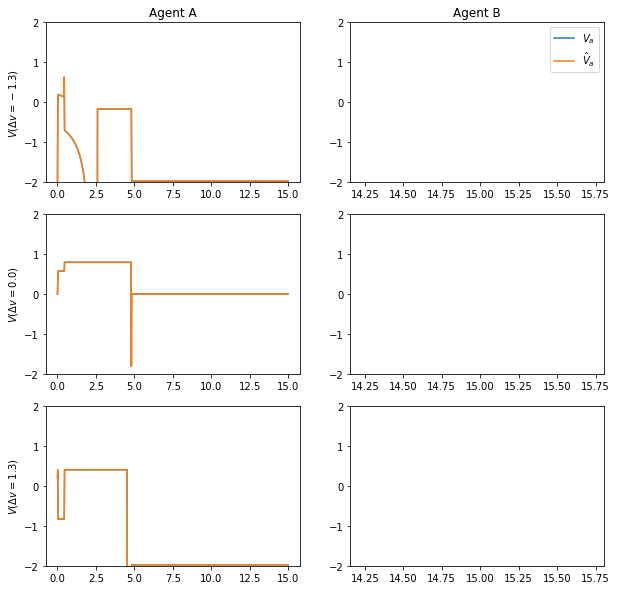

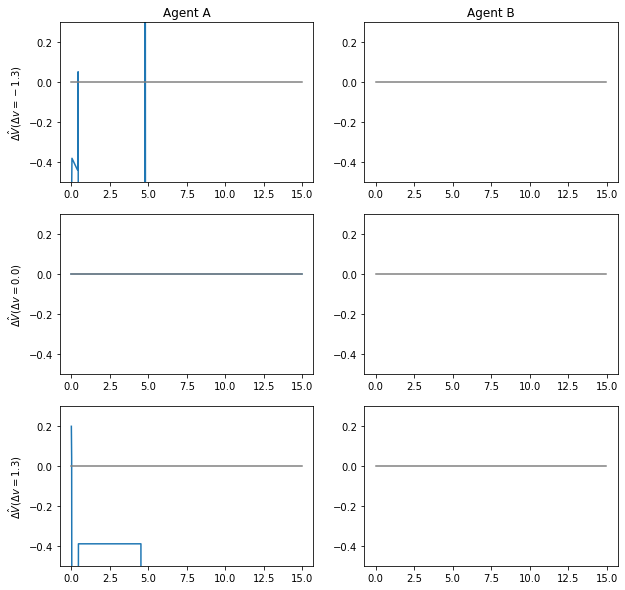

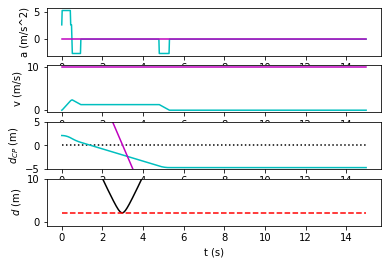

In [2]:
ped_xing_simulation = run_ped_xing_scenario(oEA = False, oAN = False)
ped_xing_simulation.do_plots(trajs = True, surplus_action_vals = True, \
    kinem_states = True, action_val_ests = True)

To see the basic, non-noisy accumulative (low-pass filtered) value estimates, we can turn on assumption `oEA`. Below I now exclude the bird's eye view trajectory plot since it always basically looks the same. In the value estimates plot it can be seen that $\hat{V}_a(t)$ (orange) now becomes a low-pass filtered version of $V_a(t)$ (blue), and the added delay in the value estimate makes the pedestrian miss its crossing-opportunity - $\hat{\Delta V}_a(t)$ almost but not quite reaches the decision threshold $\Delta V_th$ before the car has come so close that walking in front of it no longer looks desirable (the blue $V_a(t)$ goes negative about 0.5 s into the simulation).

The pedestrian started crossing the road at time 4.24 s.


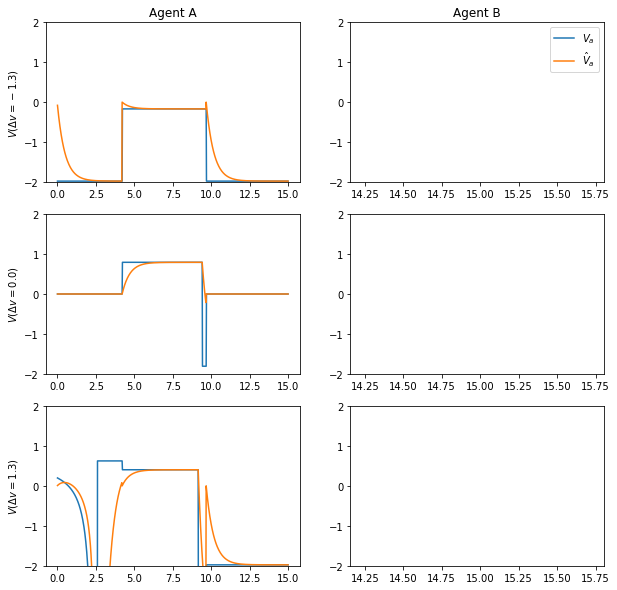

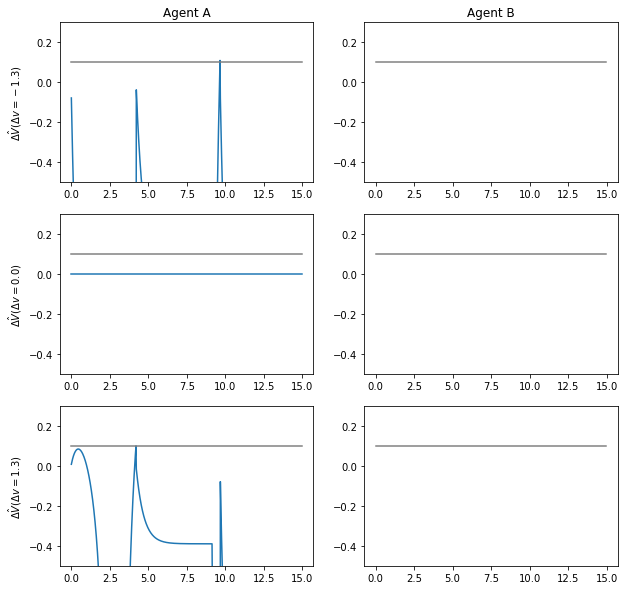

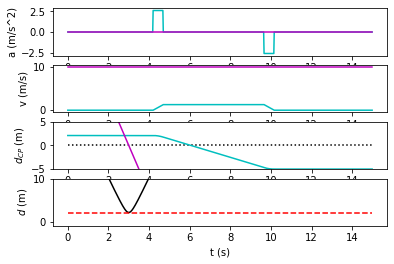

In [15]:
ped_xing_simulation = run_ped_xing_scenario(oEA = True, oAN = False)
ped_xing_simulation.do_plots(surplus_action_vals = True, \
    kinem_states = True, action_val_ests = True)

*[A side note about something I just realised from the simulation above: At time 2.5 s the car has driven sufficiently past the pedestrian such that it is possible to start crossing; this is clearly visible in the plots, since at this time $V_a(t)$ for the "speed increase" action goes from a large negative value to a positive value). From this point in time, it still takes quite some time for the pedestrian to decide to cross (almost 2 s in this case), and it is clear that this decision time will depend on how large a negative value the accumulative estimate $\hat{V}_a(t)$ reached while the car was passing. This means that the behaviour when crossing after the car will be sensitive to the exact negative value the value function ascribes to the collision risk while the car is passing - which may not be entirely desirable. I have some ideas for how one might deal with this though.]*

To see the effect of the $T$ time constant, we can increase it from the default 0.5 s that was used above to 2 s, which makes the low-pass filtered estimates slower in their following of the momentary estimates, thus slowing down the decision-making further. The pedestrian now isn't close to deciding to cross in front of the car, and takes a very long time after the car has passed to start crossing.

The pedestrian started crossing the road at time 7.26 s.


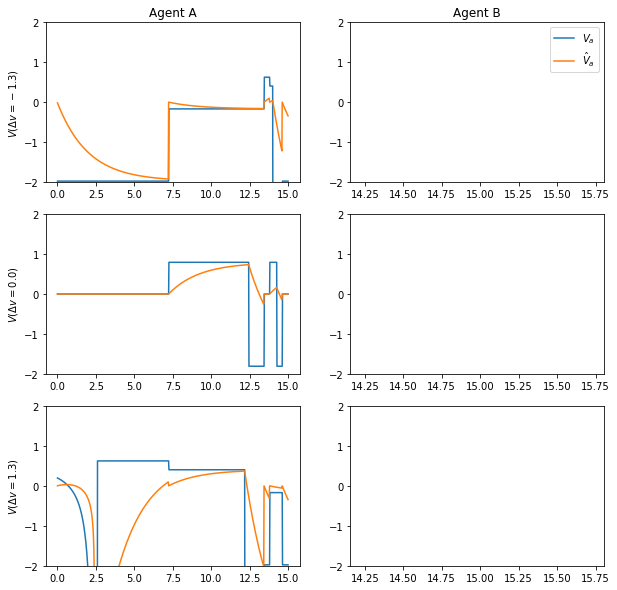

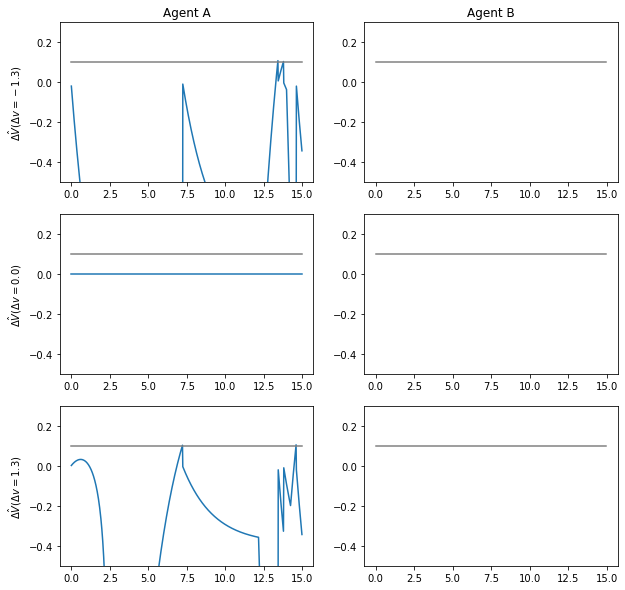

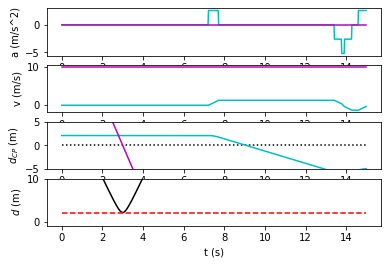

In [16]:
ped_xing_simulation = run_ped_xing_scenario(oEA = True, oAN = False, T = 2)
ped_xing_simulation.do_plots(surplus_action_vals = True, \
    kinem_states = True, action_val_ests = True)

Returning to the default $T$ = 0.5 s value, we can instead add in noise. In the example shown below, at least on my computer the random noise just barely pushes the surplus value $\Delta V_a(t)$ over the decision threshold. Since the pedestrian would experience rather low TTCs if crossing at the 1.3 m/s she just decided on, she quickly decides to again increase speed by another 1.3 m/s, effectively jogging across.

The pedestrian started crossing the road at time 0.56 s.


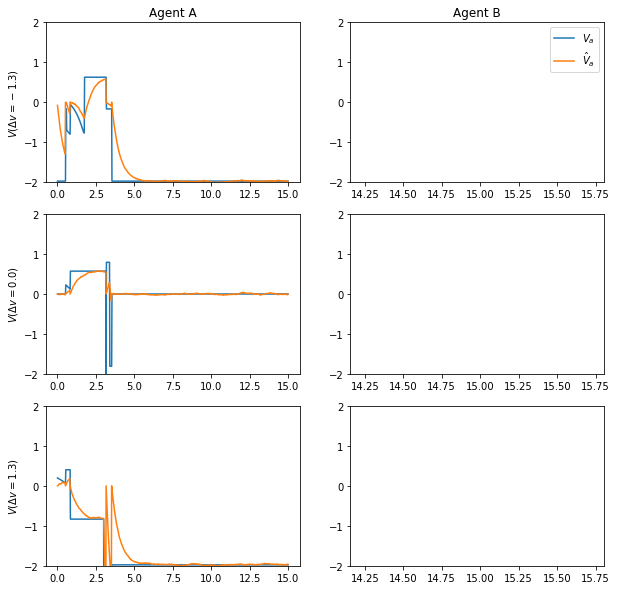

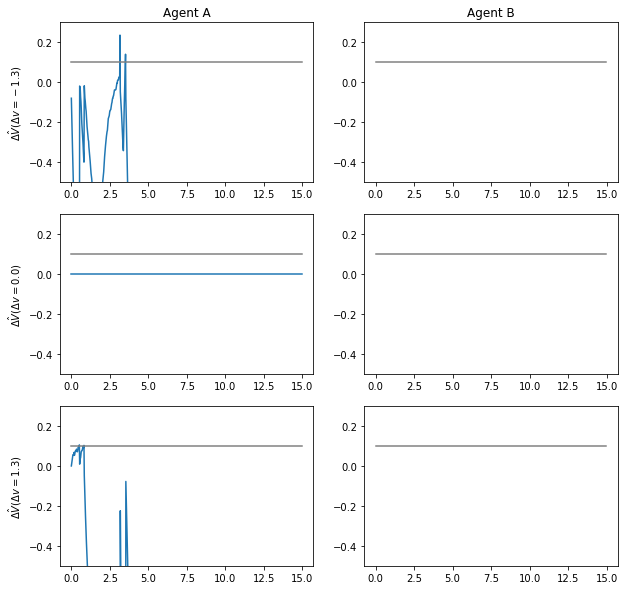

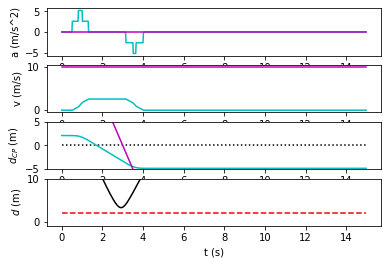

In [17]:
np.random.seed(2)
ped_xing_simulation = run_ped_xing_scenario(oEA = True, oAN = True)
ped_xing_simulation.do_plots(surplus_action_vals = True, \
    kinem_states = True, action_val_ests = True)

Running the same simulation again with a different random seed, the pedestrian does not cross before the car:

The pedestrian started crossing the road at time 4.22 s.


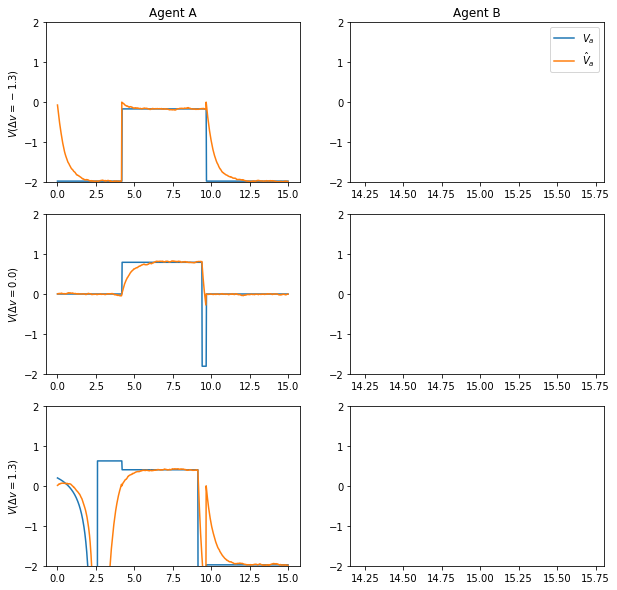

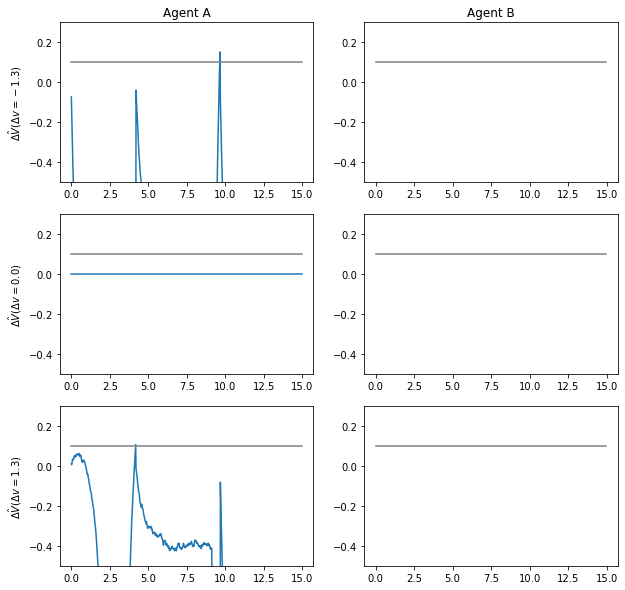

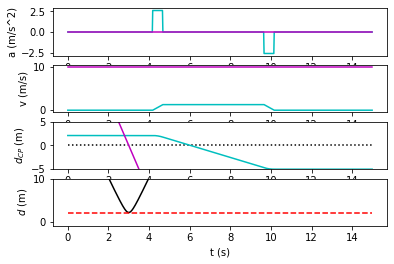

In [18]:
np.random.seed(0)
ped_xing_simulation = run_ped_xing_scenario(oEA = True, oAN = True)
ped_xing_simulation.do_plots(surplus_action_vals = True, \
    kinem_states = True, action_val_ests = True)

We can now go on to simulating the scenario a number of times to look at crossing onset distributions. Here's a function for doing that:


In [7]:
import math
import matplotlib.pyplot as plt

def run_many_ped_xing_scenarios(n_simulations = 50, \
    T = DEFAULT_T, sigma_V = DEFAULT_SIGMA_V, DeltaV_th = DEFAULT_DELTAV_TH):
    np.random.seed(0)
    xing_times = math.nan * np.ones(n_simulations)
    for i in range(n_simulations):
        xing_times[i] = run_ped_xing_scenario(oEA = True, oAN = True, return_xing_time = True, \
            T = T, sigma_V = sigma_V, DeltaV_th = DeltaV_th)
    plt.hist(xing_times, np.arange(0, 6, 0.1))
    plt.xlabel("Crossing onset time (s)")
    plt.ylabel("Count (-)")

Running it with default settings:

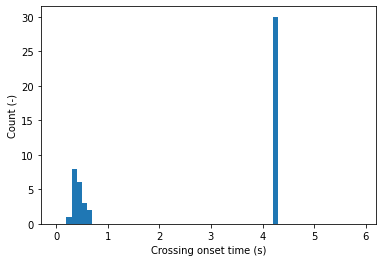

In [8]:
run_many_ped_xing_scenarios()

Two notes:
* When run like this it's clear that the COMMOTIONS framework implementation is rather slow... Not sure where the main inefficiencies are. Possibly some of it lies in the reinstantiation of the entire SCSimulation and SCAgent objects for each simulation. Code could be added for just resetting/rerunning the same simulation. However: For the purposes of just studying the pedestrian crossing decision, the simplified model itself is not so complicated - it's basically just a single action decision. Therefore the best approach is probably to code it from scratch, possibly reusing some of the helper functions from the implementation here (e.g., for predicting states into the future, calculating time to collision, etc).
* The very narrow second mode of the crossing distribution arises because of the phenomenon mentioned above, where the behaviour at this stage is mainly determined by how large a negative value gets ascribed to colliding with the car while it is passing. The dynamics of $\hat{V}_a(t)$ is determined primarily by this phenomenon, and is not so affected by the noise which is small in comparison.

Then running the same again, but now with value noise $\sigma_V$ in the accumulation decreased from 0.7 to 0.35, confirming what we know from above, that it is the noise that is creating the early crossing decisions in this specific scenario (with TTA 3 s):

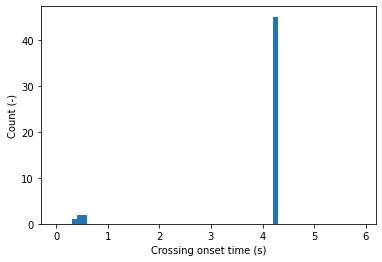

In [9]:
run_many_ped_xing_scenarios(sigma_V = 0.35)

Reverting back to the default $\sigma_V$, instead reducing $T$ from 0.5 s to 0.25 s. As expected, this yields a larger fraction of early crossers (because the crossing decision can be made before TTA of the approaching vehicle drops to too low values), and for the same reason these early crossing decisions are also quicker than the early crossing decisions with the default parameters.

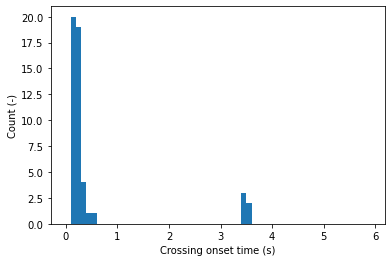

In [10]:
run_many_ped_xing_scenarios(T = 0.25)